In [66]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
import torch.nn.functional as F

In [67]:
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [68]:
bs = 8
sz = (320,240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

In [69]:
ds = NYUDataset('data/', tfms)
dl = torch.utils.data.DataLoader(ds, bs)

In [70]:
ds[0][0].shape

torch.Size([3, 240, 320])

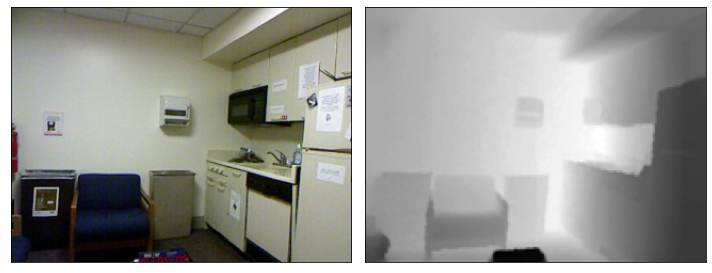

In [71]:
i = 1
plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))

#sample_batch = iter(dl).next()
#img, depth = sample_batch

In [72]:
model = Net()
model.to(device)

Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [73]:
model.load_state_dict(torch.load('all-scales-trained.ckpt', map_location="cpu"))
#model_utils.freeze_all_layers(model.VGG)
#model_utils.freeze_all_layers(model.Scale_1)
#model_utils.freeze_all_layers(model.Scale_2)

<All keys matched successfully>

In [74]:
model.train()
#n_epochs = 1
#lr = 0.0000005
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

#total_steps = 0
#for e in range(n_epochs):
#    print(f'epoch {e}')
#    for batch, labels in dl:
#        optimizer.zero_grad()
#        
#        batch = batch.to(device)
#       labels = labels.to(device)
#       
#       preds = model(batch)
#       loss = model_utils.depth_loss(preds, labels) 
#       
#       loss.backward()
#       optimizer.step()
#       
#       total_steps +=1
#                                                      
#       model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Net(
  (VGG): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [75]:
torch.save(model.state_dict(),'all-scales-trained.ckpt')

In [76]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    preds = model(img.to(device))

CPU times: user 48 s, sys: 6.4 s, total: 54.4 s
Wall time: 17.1 s


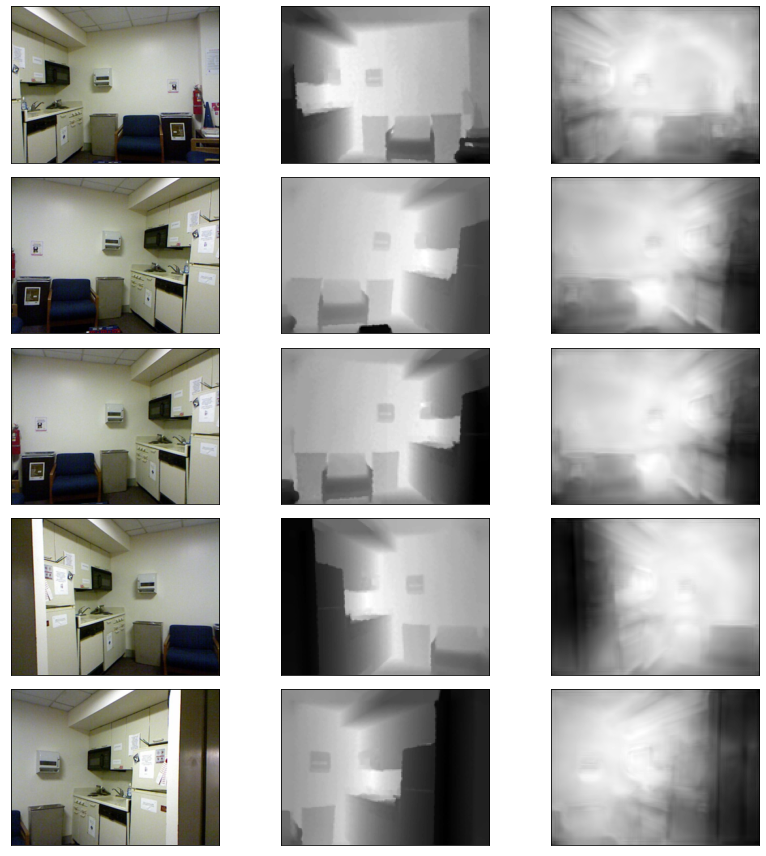

In [77]:
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

In [87]:
# No random horizontal flip
consistent_tfms = tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])
ds = NYUDataset('data/', consistent_tfms)
dl = torch.utils.data.DataLoader(ds, 20)

In [99]:
import matplotlib.pyplot as plt

#subplot utils    
def hide_subplot_axes(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def plot_image_tensor_in_subplot(ax, img_tensor):
    im = img_tensor.cpu().numpy().transpose((1,2,0))
    #pil_im = Image.fromarray(im, 'RGB')
    ax.imshow(im)

def plot_depth_tensor_in_subplot(ax, depth_tensor):
    im = depth_tensor.cpu().numpy()
    #im = im*255
    #im = im.astype(np.uint8)
    #pil_im = Image.fromarray(im, 'L')
    ax.imshow(im,'gray')

def plot_model_predictions_on_sample_batch(images, depths, preds, plot_from=0, figsize=(12,12)):
    n_items=20
    fig, axes = plt.subplots(n_items, 3, figsize=figsize)
    
    for i in range(n_items):
        plot_image_tensor_in_subplot(axes[i,0], images[plot_from+i])
        plot_depth_tensor_in_subplot(axes[i,1], depths[plot_from+i])
        plot_depth_tensor_in_subplot(axes[i,2], preds[plot_from+i])
        hide_subplot_axes(axes[i,0])
        hide_subplot_axes(axes[i,1])
        hide_subplot_axes(axes[i,2])
    
    plt.tight_layout()

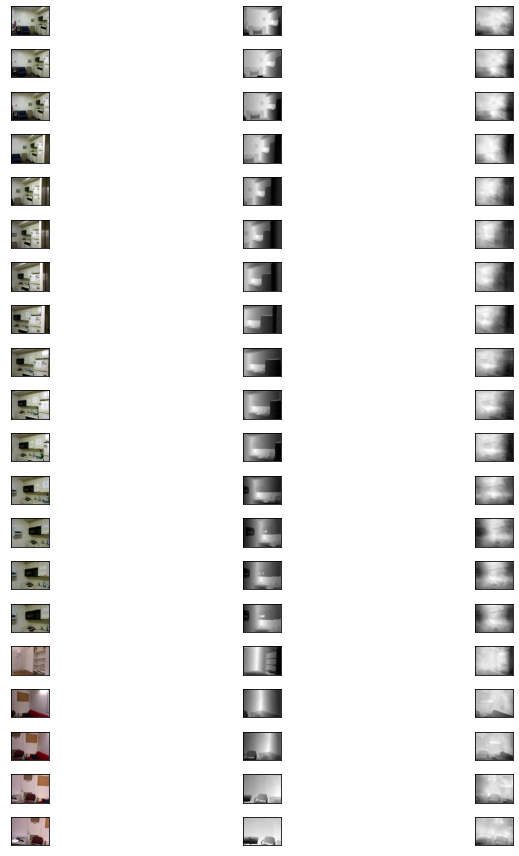

In [100]:
predictions, batch, actual_labels = model_utils.get_model_predictions_on_a_sample_batch(model, dl)
plot_model_predictions_on_sample_batch(images=unnormalize(batch), depths=actual_labels, preds=predictions.squeeze(dim=1), plot_from=0)

In [101]:
def get_model_predictions_on_a_sample_batch(m, dl_iter):
    m.eval()
    with torch.no_grad():
        batch, actual_labels = dl_iter.next()
        batch = batch.to(device)
        actual_labels = actual_labels.to(device)
        predictions = m(batch)
    
    return (predictions, batch, actual_labels)


In [146]:
dl_iter = iter(dl)

In [147]:
import numpy as np

def min_max_of_tensor(ts):
    npa = ts.cpu().numpy()
    print(np.min(npa), np.max(npa))
    
def normalize_tensor_to_np_array(ts):
    npa = ts.cpu().numpy()
    npa = (255*(npa - np.min(npa))/np.ptp(npa)).astype(int)   
    print(np.min(npa), np.max(npa))
    return npa

# We have prediction, which is 20 predictions of n x m images.
# targets is the same dimensions.
# To get the root mean squared error, we have to find 
def mean_squared_error(predictions, targets):
    return ((predictions - targets) ** 2).mean()

#https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# batch size is 20, so we are testing on the first 200 elements.
mean_squared_errors = []
images_tested = 0
for i in range(10):
    predictions, batch, actual_labels = get_model_predictions_on_a_sample_batch(model, dl_iter)
    # Predictions of depth - not normalized to 0-255 or mindepth-maxdepth scale yet
    predictions_normalized = normalize_tensor_to_np_array(predictions)
    # The images from the batch after our transformations.
    # normalize_tensor_to_np_array(batch)
    # The original, raw depth values.
    actuals_normalized = normalize_tensor_to_np_array(actual_labels)
    mean_squared_errors.append(mean_squared_error(predictions_normalized, actuals_normalized))
    print(mean_squared_errors)
import math
print(math.sqrt(sum(mean_squared_errors) / len(mean_squared_errors)))

0 255
0 255
[3934.178815625]
0 255
0 255
[3934.178815625, 3319.92991328125]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665, 9612.829500520833]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665, 9612.829500520833, 6565.195733333333]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665, 9612.829500520833, 6565.195733333333, 5722.857310677084]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665, 9612.829500520833, 6565.195733333333, 5722.857310677084, 4673.966706770833]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 7668.9183416666665, 9612.829500520833, 6565.195733333333, 5722.857310677084, 4673.966706770833, 4604.14997265625]
0 255
0 255
[3934.178815625, 3319.92991328125, 8659.46434140625, 

In [83]:
def get_model_predictions_on_list_of_images(m, imgs, labels):
    m.eval()
    with torch.no_grad():
        batch = imgs.to(device)
        actual_labels = labels.to(device)
        predictions = m(batch)
    return (predictions, batch, actual_labels)

In [84]:
import model_utils
first_5 = [ds[i] for i in range(5)]
imgs = [el[0] for el in first_5]
labels = [el[1] for el in first_5]
predictions, batch, actual_labels = get_model_predictions_on_list_of_images(model, imgs, labels)
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(batch), depths=actual_labels, preds=predictions.squeeze(dim=1), plot_from=0)

NameError: name 'tensor' is not defined

In [ ]:
test_tfms = transforms.Compose([
    transforms.Resize((240,320)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
import PIL
from PIL import Image

im = Image.open('IMG_4120.jpg').rotate(180)
res = test_tfms(im)

model.eval()
pred = model(res[None].to(device))

In [ ]:
pred_numpy_arr = pred.detach().squeeze(dim=1).squeeze(dim=0).cpu().numpy()
pred_numpy_arr = pred_numpy_arr - pred_numpy_arr.min()       # -0.660375
pred_numpy_arr = (pred_numpy_arr/pred_numpy_arr.max())*255   # max = 2.1548061, brings scale to 0-255  
pred_numpy_arr = pred_numpy_arr.astype('uint8')

In [ ]:
im.resize((320,240), resample=PIL.Image.BILINEAR)

In [ ]:
Image.fromarray(pred_numpy_arr, mode = 'L').resize((320, 240))

In [ ]:
T, P = transforms.ToTensor(), transforms.ToPILImage()
dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(ds[10], unnormalize, T, P)

In [ ]:
P(g)

In [ ]:
from IPython.display import FileLink
FileLink('all-scales-trained.ckpt')